In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import shuffle

In [2]:
df = pd.read_json('logins.json')

In [3]:
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [5]:
def minute(login_time):
    
    return login_time.minute

In [6]:
def hour(login_time):
    
    return login_time.hour

In [7]:
def minute_count(login_time):
    
    
    if login_time.minute<15:

        return 0

    elif 15<login_time.minute<30:

        return 1

    elif 30<login_time.minute<45:

        return 2

    else:

        return 3

In [8]:
def day_of_week(login_time):
    
    return login_time.weekday_name

In [9]:
def month(login_time):
    
    return login_time.month

In [10]:
def plot_metrics(x,y,xlabel,ylabel,title,figsize):
    
    fig,ax = plt.subplots()
    fig.set_size_inches(figsize[0],figsize[1])
    ax.bar(x,y)
    ax.set_title(title,fontsize=18)
    ax.set_xlabel(xlabel,fontsize=18)
    ax.set_ylabel(ylabel,fontsize=18)
    plt.show()

In [11]:
def half_year_active_account(df):
    
    labels = []
    
    for idx in range(len(df)):
    
        if df.last_trip_date.iloc[idx].month - df.signup_date.iloc[idx].month > 5:

            labels.append(1)

        else:

            if df.last_trip_date.iloc[idx].year - df.signup_date.iloc[idx].year > 0:

                labels.append(1)

            else:

                labels.append(0)
            
    return labels

In [12]:
df['minute_interval'] = df.login_time.apply(minute_count)

In [13]:
df_minutes = df.groupby(df.minute_interval).count()

In [14]:
df_minutes.index = ['0-14','15-29','30-44','45-59']

In [15]:
df_minutes.index.name = 'minute_interval'

In [16]:
df_minutes

,login_time
minute_interval,
0-14,22660
15-29,21473
30-44,22446
45-59,26563


In [17]:
df['hour'] = df.login_time.apply(hour)

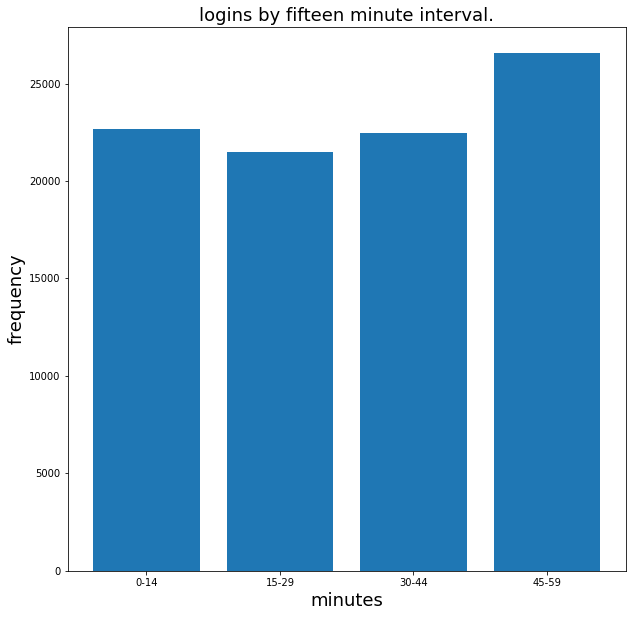

In [18]:
# Majority of logins occur in the last quarter of an hour.
plot_metrics(df_minutes.index.values,df_minutes.values.reshape(len(df_minutes)),'minutes','frequency',\
                                                               'logins by fifteen minute interval.',(10,10))

In [19]:
df['day'] = df.login_time.apply(day_of_week)

/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: `weekday_name` is deprecated and will be removed in a future version. Use `day_name` instead
  This is separate from the ipykernel package so we can avoid doing imports until


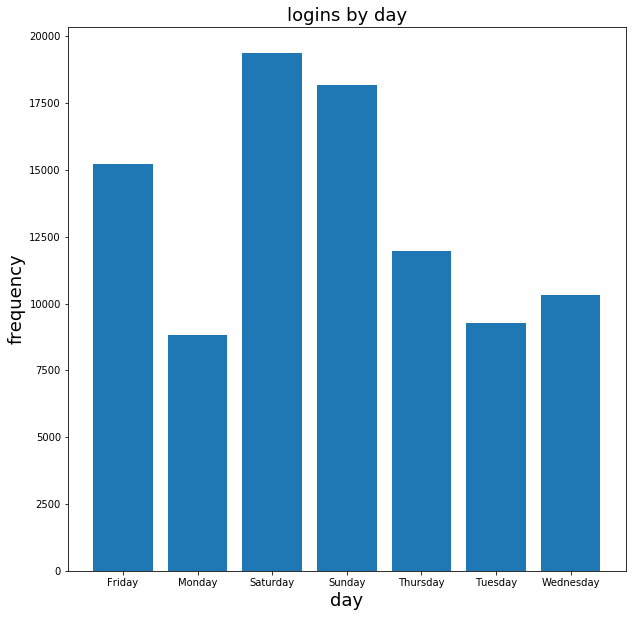

In [20]:
# Majority of logins occur on Saturdays.
plot_metrics(df['day'].value_counts().index,df['day'].value_counts().values,'day','frequency','logins by day',(10,10))

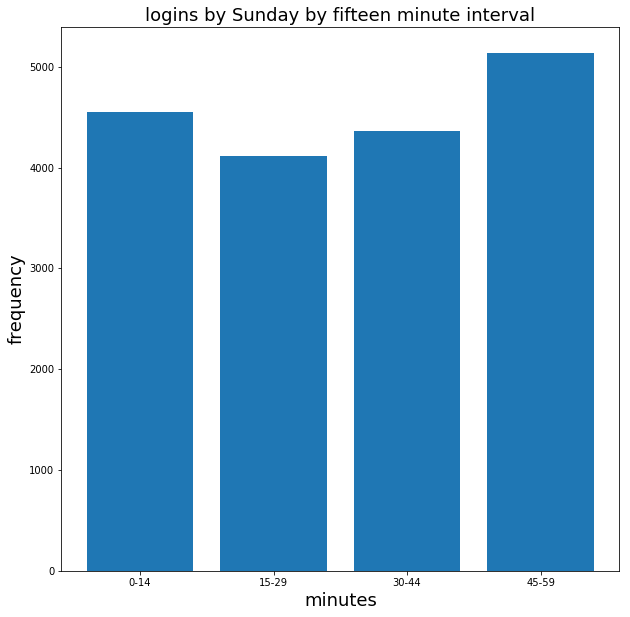

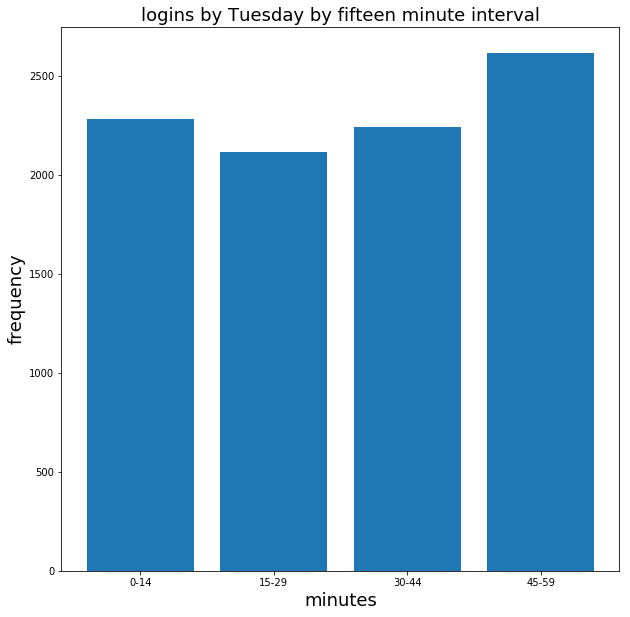

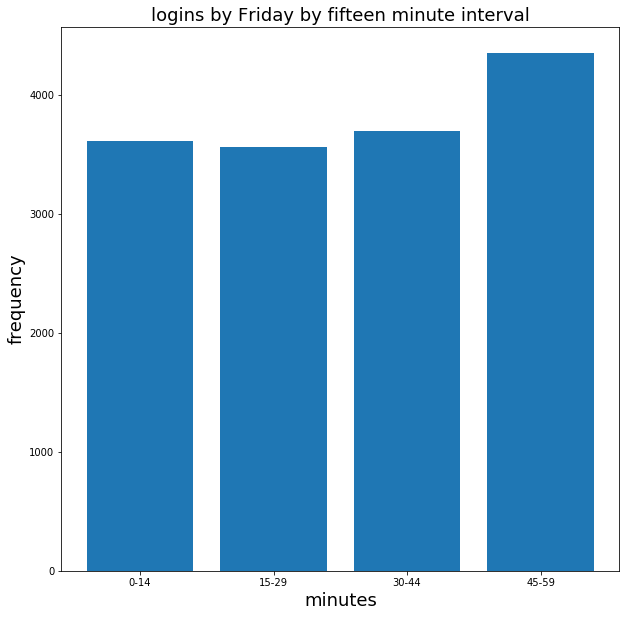

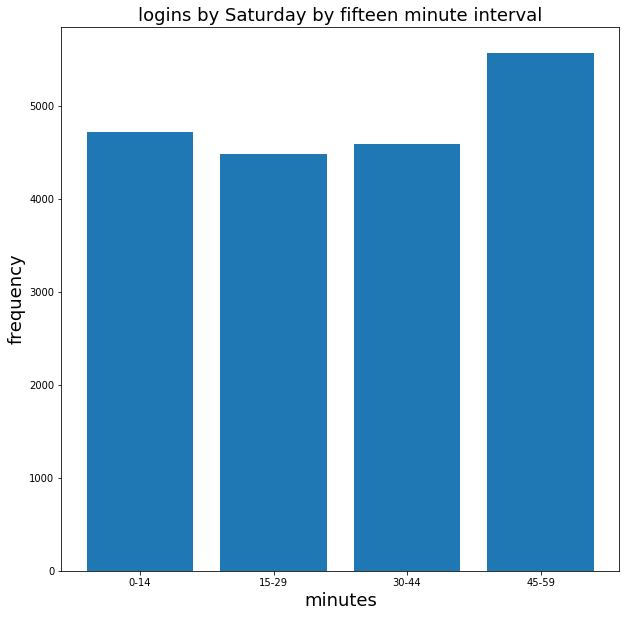

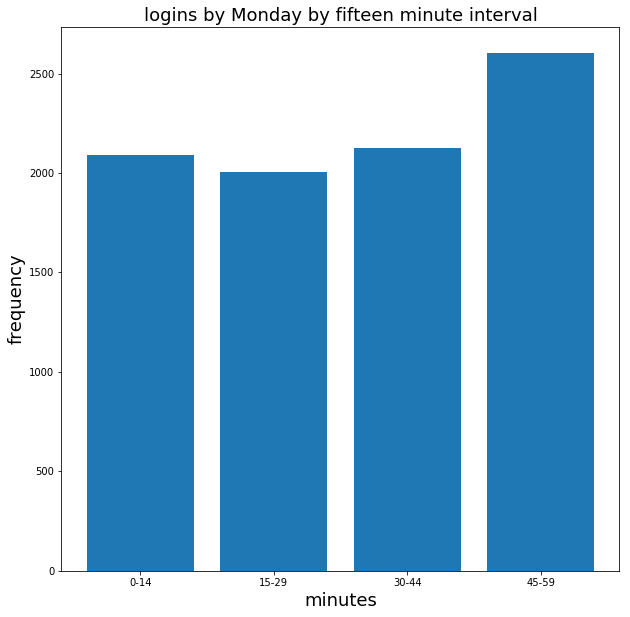

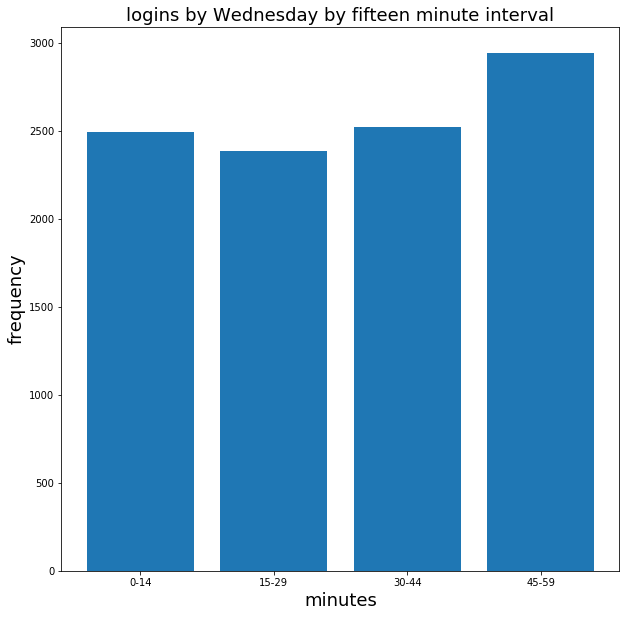

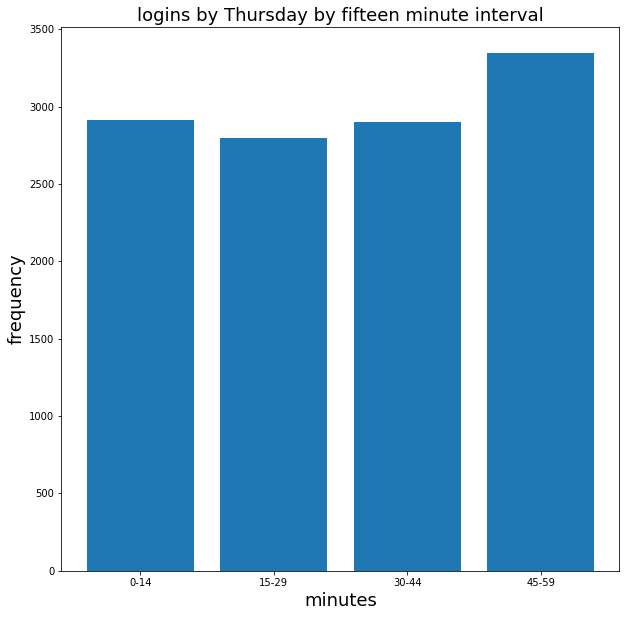

In [21]:
# Projecting the data onto a daily time format shows the last quarter of an hour still has the largest occurence of
# logins. This trend is noted for each day.
for day in set(df['day'].values):
    
    df_daily_minutes = df['login_time'][df['day']==day]
    df_daily_minutes['minute_interval'] = df_daily_minutes.apply(minute_count)
    df_daily_minutes = df.groupby(df_daily_minutes.minute_interval).count()['minute_interval']
    df_daily_minutes.index = ['0-14','15-29','30-44','45-59']
    df_daily_minutes.index.name = 'minute_interval'
    plot_metrics(df_daily_minutes.index.values,df_daily_minutes.values.reshape(len(df_daily_minutes)),'minutes',\
                'frequency','logins by ' + day + ' by fifteen minute interval',(10,10))

In [22]:
count = 1
hours = {}

for idx in range(24):
    
    if idx < 12:
        
        if idx == 0:
            
            hours[idx] = '12 AM'
        
        else:
            
            hours[idx] = str(idx) + ' AM'
        
    else:
        
        if idx > 12:
            
            hours[idx] = str(count) + ' PM'
            
            count += 1
            
        else:
        
            hours[idx] = str(idx) + ' PM'

In [23]:
df_hours = df.groupby(df.hour).count()['login_time']

In [24]:
hours_idx = [hours[hour] for hour in df_hours.index.values]

In [25]:
df_hours.index = hours_idx

In [26]:
df_hours.index.name = 'hour'

In [27]:
df_hours.sort_values(ascending=False)

hour
10 PM    6607
1 AM     6317
11 PM    6058
12 AM    5993
2 AM     5800
11 AM    5799
9 PM     5623
4 AM     5034
12 PM    4964
3 AM     4831
8 PM     4103
1 PM     3611
2 PM     3426
7 PM     3235
10 AM    3064
3 PM     3038
6 PM     2980
5 AM     2945
4 PM     2832
5 PM     2584
9 AM     1527
6 AM     1138
8 AM      818
7 AM      815
Name: login_time, dtype: int64

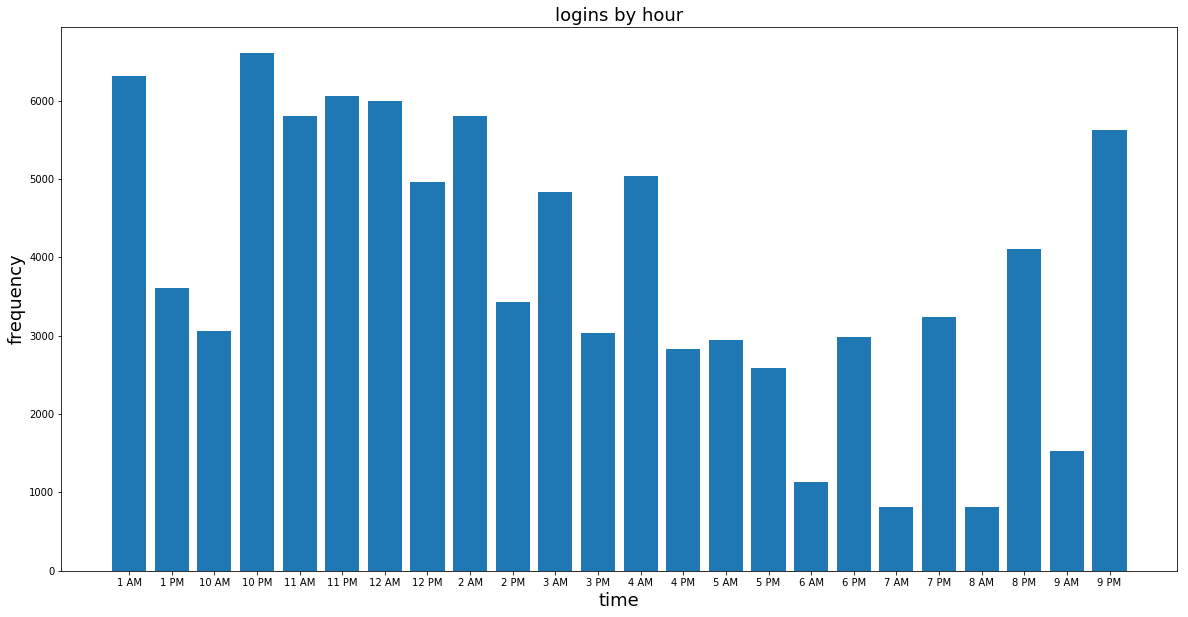

In [28]:
# On an hourly time scale logins peak at Eleven in the morning and Ten at night.
plot_metrics(df_hours.index.values,df_hours.values,'time','frequency','logins by hour',(20,10))

In [29]:
months = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}

In [30]:
df['month'] = df.login_time.apply(month)

In [31]:
df_month = df.groupby('month').count()['login_time']

In [32]:
df_month_index = [months[idx] for idx in df_month.index.values]

In [33]:
df_month.index = df_month_index

In [34]:
df_month.index.name = 'month'

In [35]:
df_month.sort_values(ascending=False)

month
Mar    33723
Feb    24673
Jan    21239
Apr    13507
Name: login_time, dtype: int64

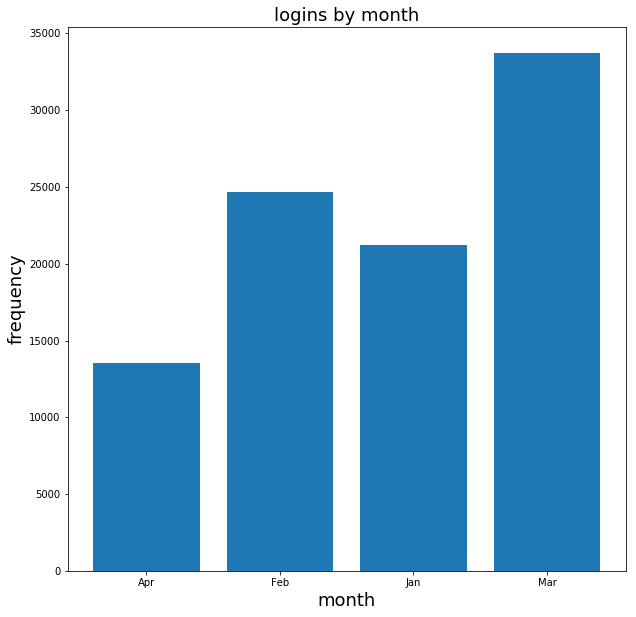

In [36]:
# March has the largest login total.
plot_metrics(df_month.index.values,df_month.values,'month','frequency','logins by month',(10,10))

In [37]:
df_march_hours = df[df.month==3].groupby(df.hour).count()['login_time']

In [38]:
df_march_hours.sort_values(ascending=False)

hour
22    2478
1     2297
23    2245
0     2160
11    2121
21    2093
2     2052
4     1815
12    1713
3     1699
20    1533
19    1282
13    1255
14    1189
18    1186
10    1136
15    1074
16    1000
17     982
5      981
9      509
6      379
8      297
7      247
Name: login_time, dtype: int64

In [39]:
hours_idx = [hours[hour] for hour in df_march_hours.index.values]

In [40]:
df_march_hours.index = hours_idx

In [41]:
df_march_hours.index.name = 'hour'

In [42]:
df_march_hours.sort_values(ascending=False)

hour
10 PM    2478
1 AM     2297
11 PM    2245
12 AM    2160
11 AM    2121
9 PM     2093
2 AM     2052
4 AM     1815
12 PM    1713
3 AM     1699
8 PM     1533
7 PM     1282
1 PM     1255
2 PM     1189
6 PM     1186
10 AM    1136
3 PM     1074
4 PM     1000
5 PM      982
5 AM      981
9 AM      509
6 AM      379
8 AM      297
7 AM      247
Name: login_time, dtype: int64

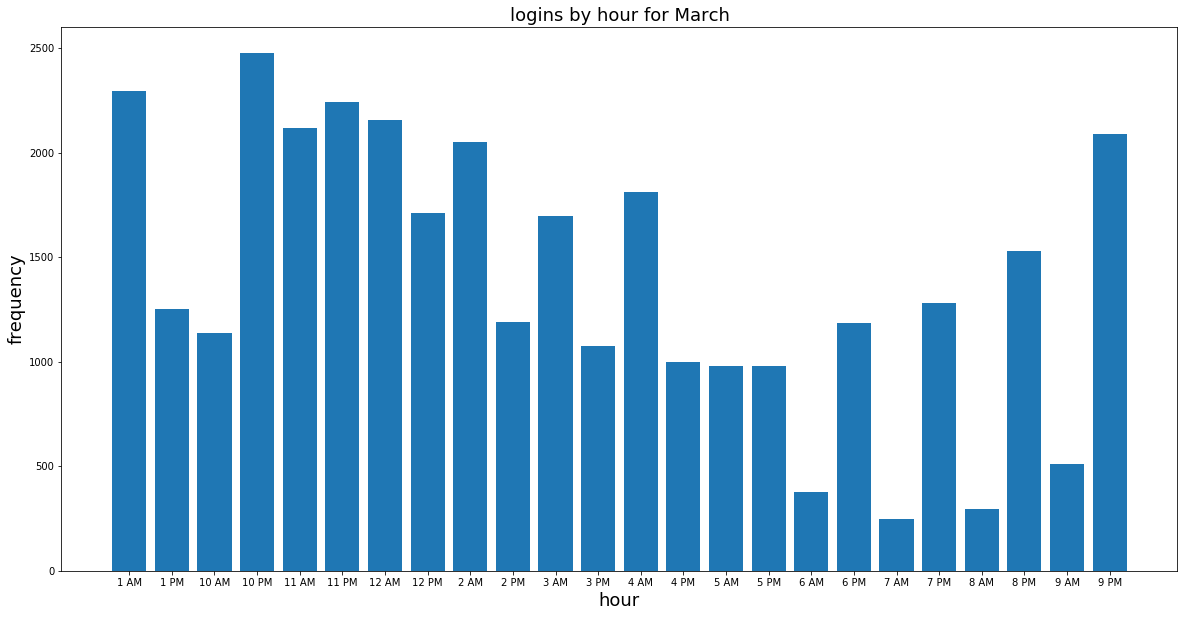

In [43]:
# On an hourly time scale for March it is once again noted that peak login times occur at Eleven for the day and Ten for 
# the night.
plot_metrics(df_march_hours.index.values,df_march_hours.values,'hour','frequency','logins by hour for March',(20,10))

In [44]:
# The key measure of success for the Gotham and Metropolis areas experiment is the coefficient 
# of determination. This metric is chosen as it depicts how well the model fits the variation in the targets.
# The more the explained variance reflects the total variance the more accurate the model.

In [45]:
# A model with location and driver per passenger pickup as additional features is compared, based on an F-test, with 
# the same model utilizing a subset of features to predict whether a passenger will be retained after a given period of time
# along with the amount of trips taken within that time. 

In [46]:
# This would determine two measures of success for the experiment. The first being if drivers were serving both areas
# while the second would indicate the effect of the experiment on passenger retension.

In [47]:
# To implement this experiment a time period would be set and data wrangled. 
# Followed by two separate model constructions.
# The F-test is utilized to compare models and determine if additional features increase models fit and overall accuracy.
# F-statistic ~ model significance ~ feature significance ~ model accuracy.
# If additional features increase models accuracy and indicate drivers are servicing multiple areas, thus increasing
# passenger activity and retension, then the experiment is a success for toll reimbursement. Otherwise additional avenues
# will need to be explored.

In [48]:
fh = open('ultimate_data_challenge.json','r')

In [49]:
df = pd.DataFrame(json.load(fh))

In [50]:
df = df.dropna()

In [51]:
df['last_trip_date'] = df['last_trip_date'].astype('datetime64')

In [52]:
df['signup_date'] = df['signup_date'].astype('datetime64')

In [53]:
df = pd.concat([df,pd.get_dummies(df.city)],axis=1)

In [54]:
df = df.drop(['city'],axis=1)

In [55]:
df = pd.concat([df,pd.get_dummies(df.phone)],axis=1)

In [56]:
df = df.drop(['phone'],axis=1)

In [57]:
df.ultimate_black_user = df.ultimate_black_user*1

In [58]:
normalized_columns = ['avg_dist','avg_rating_by_driver','avg_rating_of_driver','avg_surge','surge_pct','weekday_pct']

In [59]:
df[normalized_columns] = (df[normalized_columns].values - df[normalized_columns].values.mean(axis=0))/df[normalized_columns].values.std(axis=0)

In [60]:
df['retained'] = [1 if trip > 0 else 0 for trip in df.trips_in_first_30_days]

In [61]:
df['half_year_active_account'] = half_year_active_account(df)

In [62]:
df = df.drop(['last_trip_date','signup_date','trips_in_first_30_days'],axis=1)

In [63]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,Astapor,King's Landing,Winterfell,Android,iPhone,retained,half_year_active_account
0,-0.347912,0.552529,0.159520,0.131718,0.354838,1,-0.432445,0,1,0,0,1,1,0
1,0.544197,0.552529,0.646456,-0.371440,-0.485689,0,-0.323292,1,0,0,1,0,0,0
2,-0.911554,0.552529,-0.489729,-0.371440,-0.485689,0,1.112936,1,0,0,0,1,1,0
3,-0.602523,0.305372,-0.002792,0.332981,0.605905,1,0.538445,0,1,0,0,1,1,0
4,-0.452866,0.305372,-0.327417,0.584560,0.158351,0,0.607384,0,0,1,1,0,1,0


In [64]:
len(df[df.retained==0])

11524

In [65]:
len(df[df.retained==1])

29921

In [66]:
100 * len(df[df.retained==1])/(len(df[df.retained==1]) + len(df[df.retained==0]))

72.19447460489806

In [67]:
len(df[df.half_year_active_account==0])

40916

In [68]:
len(df[df.half_year_active_account==1])

529

In [69]:
sample_replication = len(df[df.half_year_active_account==0])//len(df[df.half_year_active_account==1])

In [70]:
df_replication = pd.DataFrame()

In [71]:
for idx in range(sample_replication-1):
    
    df_replication = pd.concat([df_replication,df[df.half_year_active_account==1]],axis=0)

In [72]:
df = pd.concat([df,df_replication],axis=0)

In [73]:
df = pd.DataFrame(shuffle(df.values),columns=df.columns)

In [74]:
X,Y = df.values[:,:-1],df.values[:,-1]
xtr,xte,ytr,yte = train_test_split(X,Y,test_size=.2,stratify=Y)
xtr,xval,ytr,yval = train_test_split(xtr,ytr,test_size=.2,stratify=ytr)
columns = df.columns[:-1]
df_train = pd.DataFrame(xtr,columns=columns)
df_val = pd.DataFrame(xval,columns=columns)
df_test = pd.DataFrame(xte,columns=columns)
train = xgb.DMatrix(df_train,label=ytr)
val = xgb.DMatrix(df_val,label=yval)
test = xgb.DMatrix(df_test,label=yte)
num_rounds = 1000
params = {'max_depth':5,'objective':'binary:logistic'}
evallist = [(train,'train'),(val,'eval')]
bst = xgb.train(params,train,num_rounds,evallist,early_stopping_rounds=10)

[0]	train-error:0.262348	eval-error:0.263013
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 10 rounds.
[1]	train-error:0.242178	eval-error:0.239054
[2]	train-error:0.239633	eval-error:0.238365
[3]	train-error:0.228457	eval-error:0.225505
[4]	train-error:0.223692	eval-error:0.22053
[5]	train-error:0.219443	eval-error:0.218769
[6]	train-error:0.214123	eval-error:0.213028
[7]	train-error:0.212783	eval-error:0.211191
[8]	train-error:0.207999	eval-error:0.208588
[9]	train-error:0.198756	eval-error:0.200475
[10]	train-error:0.196842	eval-error:0.199709
[11]	train-error:0.19734	eval-error:0.19925
[12]	train-error:0.194929	eval-error:0.197107
[13]	train-error:0.194182	eval-error:0.195499
[14]	train-error:0.190585	eval-error:0.192208
[15]	train-error:0.183351	eval-error:0.185931
[16]	train-error:0.181686	eval-error:0.185778
[17]	train-error:0.181418	eval-error:0.185854
[18]	train-error:0.181896	eval-error:0.1

[175]	train-error:0.023404	eval-error:0.031307
[176]	train-error:0.02329	eval-error:0.031078
[177]	train-error:0.022677	eval-error:0.030465
[178]	train-error:0.02239	eval-error:0.030159
[179]	train-error:0.022084	eval-error:0.02947
[180]	train-error:0.020419	eval-error:0.028169
[181]	train-error:0.020036	eval-error:0.02771
[182]	train-error:0.020036	eval-error:0.027633
[183]	train-error:0.019807	eval-error:0.02748
[184]	train-error:0.019462	eval-error:0.027404
[185]	train-error:0.019003	eval-error:0.026868
[186]	train-error:0.018946	eval-error:0.026408
[187]	train-error:0.01885	eval-error:0.026868
[188]	train-error:0.01885	eval-error:0.026638
[189]	train-error:0.018563	eval-error:0.027021
[190]	train-error:0.018371	eval-error:0.026638
[191]	train-error:0.018123	eval-error:0.026562
[192]	train-error:0.017702	eval-error:0.025566
[193]	train-error:0.017663	eval-error:0.025413
[194]	train-error:0.017568	eval-error:0.02526
[195]	train-error:0.01751	eval-error:0.025031
[196]	train-error:0.01

[351]	train-error:0.003847	eval-error:0.011099
[352]	train-error:0.003827	eval-error:0.011176
[353]	train-error:0.003827	eval-error:0.011099
[354]	train-error:0.003866	eval-error:0.011099
[355]	train-error:0.003866	eval-error:0.011099
[356]	train-error:0.003866	eval-error:0.011099
[357]	train-error:0.003808	eval-error:0.011099
[358]	train-error:0.003732	eval-error:0.011176
[359]	train-error:0.003732	eval-error:0.011405
[360]	train-error:0.003693	eval-error:0.011482
Stopping. Best iteration:
[350]	train-error:0.003847	eval-error:0.011099



In [75]:
predictions = np.round(bst.predict(test))

In [76]:
np.mean(predictions==yte)

0.9900183710961421

In [77]:
print(classification_report(predictions,yte))

             precision    recall  f1-score   support

        0.0       0.98      1.00      0.99      8020
        1.0       1.00      0.98      0.99      8310

avg / total       0.99      0.99      0.99     16330



Text(0.5,0,'weight')

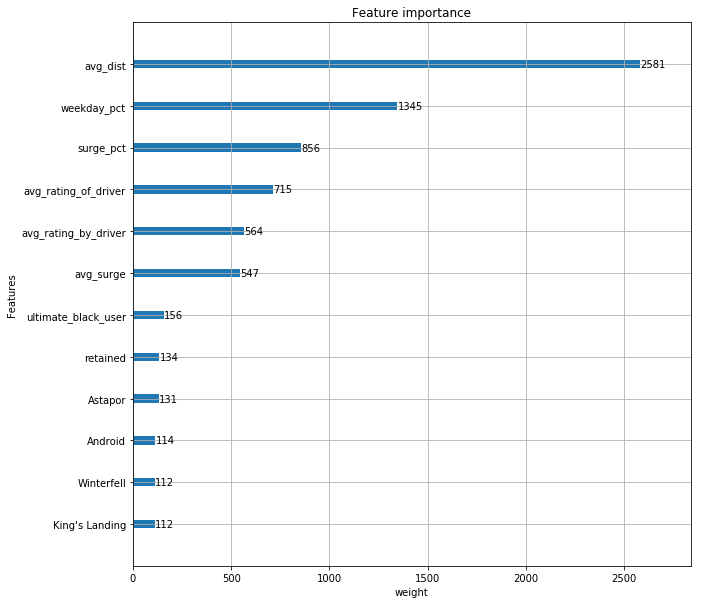

In [78]:
# Number of times a feature appears in a tree across ensemble.
fig,ax = plt.subplots()
fig.set_size_inches(10,10)
xgb.plot_importance(bst,importance_type='weight',ax=ax)
ax.set_xlabel('weight')

Text(0.5,0,'gain')

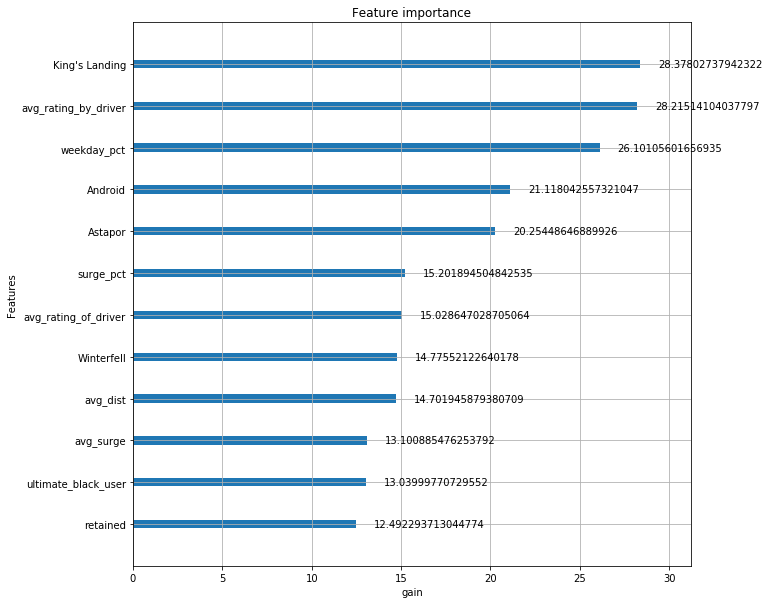

In [79]:
# Avg information gain per split per feature.
fig,ax = plt.subplots()
fig.set_size_inches(10,10)
xgb.plot_importance(bst,importance_type='gain',ax=ax)
ax.set_xlabel('gain')

Text(0.5,0,'cover')

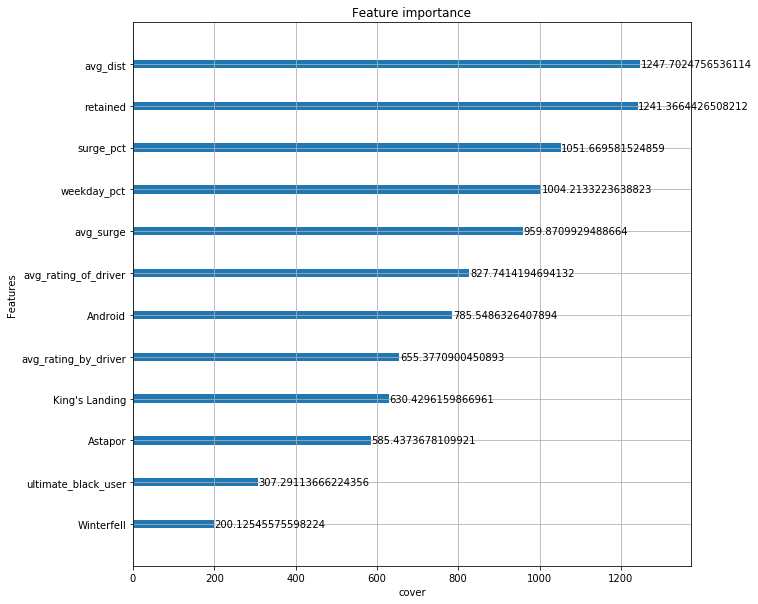

In [80]:
# Number of samples per splits per feature. 
fig,ax = plt.subplots()
fig.set_size_inches(10,10)
xgb.plot_importance(bst,importance_type='cover',ax=ax)
ax.set_xlabel('cover')

In [81]:
# A boosted random forest ensemble was utilized for model construction. The main issue was that of class imbalance 
# in terms of inactive users after half a year being seveny-seven times more represented in the sample count.
# To balance this, active user samples were duplicated, though this creates issues of its own, as it trains the model on 
# a datset, that most likely will not accurately reflect encountered population variance with tested data, regarding active
# users for six month periods of time. Thus, leading to overfitting. Feature importance was viewed from three separate 
# distinctions, that being occurence across ensemble, amount of information gain per split, and sample count for all splits.
# Additional techniques for detecting feature importance that were not used include clustering, principal component 
# analysis, and lasso regularization. Driver ratings, distance traveled, and weekdays appear to be the most influential 
# in the ensemble followed by location of signup and device type. This indicates that metrics related to the trip are
# likely to produce a more accurate model.